# Phandelver Probabilities

## Setup

Let's explore some of the dice roll probabilities in the [Lost Mine of Phandelver](https://www.dndbeyond.com/sources/lmop) D&D adventure (on D&D Beyond)!

### Party

The [Pregenerated CharactersPregenerated Characters](https://www.dndbeyond.com/sources/lmop/introduction#PregeneratedCharacters):

1. [Dwarven ClericDwarven Cleric (231 KB PDF)](https://www.dndbeyond.com/file-attachments/0/776/dwarf-cleric.pdf)
2. [Elven Wizard (219 KB PDF)](https://www.dndbeyond.com/file-attachments/0/777/elf-wizard.pdf)
3. [Halfling Rogue (202 KB PDF)](https://www.dndbeyond.com/file-attachments/0/778/halfling-rogue.pdf)
4. [Human Fighter 1 (189 KB PDF)](https://www.dndbeyond.com/file-attachments/0/779/human-fighter.pdf)
5. [Human Fighter 2 (188 KB PDF)](https://www.dndbeyond.com/file-attachments/0/780/human-fighter2.pdf)

### Load Python Code

In [56]:
# Standard library
from itertools import product

# Third-party
import matplotlib.pyplot as plot
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
plot.style.use("ggplot")


def compute_roll_chance(modifier=0):
    d20 = np.arange(1 + modifier, 21 + modifier)
    disadvantage_roll = (((20 - (d20 - 1 - modifier)) ** 2) / 20**2) * 100
    normal_roll = ((20 - (d20 - 1 - modifier)) / 20) * 100
    advantage_roll = ((20**2 - (d20 - 1 - modifier) ** 2) / 20**2) * 100
    roll_chance = np.array(
        [
            d20.tolist(),
            disadvantage_roll.tolist(),
            normal_roll.tolist(),
            advantage_roll.tolist(),
        ]
    )
    return roll_chance


def print_success_chance_arrays(modifier=0):
    roll_chance = compute_roll_chance(modifier)
    with np.printoptions(formatter={"float": "{:0.2f}".format}):
        print(roll_chance.transpose())


def roll(modifier=0, advantage=False, disadvantage=False):
    roll_chance = compute_roll_chance(modifier)
    if (advantage is True and disadvantage is True) or (
        advantage is False and disadvantage is False
    ):
        row = 2  # normal roll
    elif advantage is True:
        row = 3  # advantage roll
    else:
        row = 1  # disadvantage roll
    return roll_chance, row


def success_chance(dc, modifier=0, advantage=False, disadvantage=False):
    roll_chance, row = roll(modifier, advantage, disadvantage)
    if dc < roll_chance[0][0]:
        return 100
    elif dc > roll_chance[0][-1]:
        return 0
    return roll_chance[row][dc - 1 - modifier]


def plot_success_chance(modifier=0):
    roll_chance = compute_roll_chance(modifier)

    fig, ax = plot.subplots()

    ax.bar(roll_chance[0], roll_chance[3], label="advantage")
    ax.bar(roll_chance[0], roll_chance[2], label="normal roll")
    ax.bar(roll_chance[0], roll_chance[1], label="disadvantage")

    ax.set_title(
        "Advantage, normal roll, and disadvantage probabilities\n"
        f"with modifier of {modifier:+1d}"
    )
    ax.set_xlabel("DC (Difficulty Class)")
    ax.set_ylabel("Probability of rolling DC or higher")

    major_ticks = list(range(5 + modifier, 21 + modifier, 5))
    minor_ticks = [
        x
        for x in list(range(1 + modifier, 20 + modifier))
        if x not in major_ticks
    ]
    ax.xaxis.set_major_locator(ticker.FixedLocator(major_ticks))

    ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_tick_params(which="minor", length=4, colors="gray")

    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

    ax.legend()

### Roll Probabilities Plot

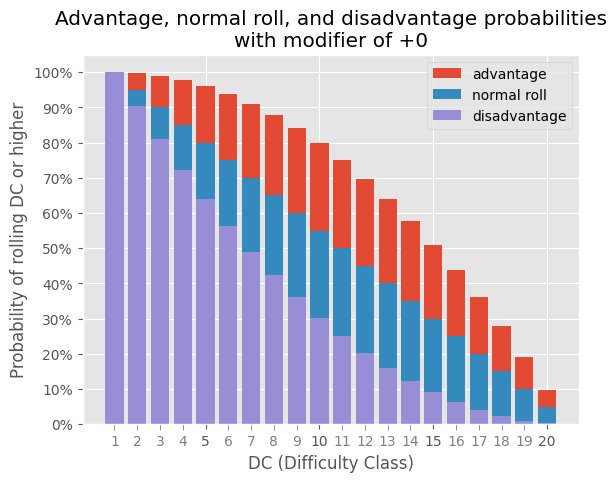

In [2]:
plot_success_chance()

## Goblin Ambush

Four [Goblins](https://www.dndbeyond.com/monsters/16907-goblin) attempt to ambush the party. Their stealth modifier is +6 vs the party's passive perception. Will they surprise everyone in the party?

In [55]:
goblin_stealth_modifier = 6
party_passive_perception = (
    ("Dwarven Cleric:", 13),
    ("Elf Wizard:", 13),
    ("Halfling Rogue:", 10),
    ("Human Fighter 1:", 13),
    ("Human Fighter 2:", 13),
)
total_chance = []
print("Observation chance:")
for player, passive_perception in party_passive_perception:
    chance = 100 - success_chance(
        passive_perception, modifier=goblin_stealth_modifier
    )
    print(f"    {player:<15}{chance: 3.0f}%")
    total_chance.append(chance)
total_chance = np.array(total_chance)
print()
print(
    f"There is a {total_chance.mean():.0f}% chance the players will see the"
    " hiding goblins."
)

Observation chance:
    Dwarven Cleric: 30%
    Elf Wizard:     30%
    Halfling Rogue: 15%
    Human Fighter 1: 30%
    Human Fighter 2: 30%

There is a 27% chance the players will see the hiding goblins.


Next, initiave order is determined.

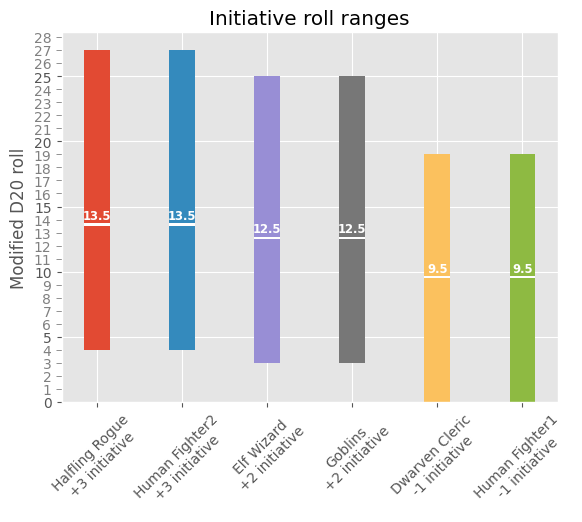

In [7]:
initiative = [
    ("Dwarven Cleric\n-1 initiative", -1),
    ("Elf Wizard\n+2 initiative", 2),
    ("Halfling Rogue\n+3 initiative", 3),
    ("Human Fighter1\n-1 initiative", -1),
    ("Human Fighter2\n+3 initiative", 3),
    ("Goblins\n+2 initiative", 2),
]

initiative_arrays = []
for player, modifier in initiative:
    initiative_arrays.append([player, np.arange(1 + modifier, 21 + modifier)])
initiative_arrays = sorted(
    initiative_arrays, key=lambda x: x[1].mean(), reverse=True
)

fig, ax = plot.subplots()

i = 1
for player, array in initiative_arrays:
    ax.bar(i, array, width=0.3, bottom=array[0], label=player)
    ax.bar(i, 0.2, width=0.3, bottom=array.mean(), color="white")
    ax.annotate(
        array.mean(),
        (i, array.mean() + 0.5),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="center",
    )
    i += 1

ax.set_title("Initiative roll ranges")
ax.set_ylabel("Modified D20 roll")

ax.xaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in initiative_arrays])
)
ax.xaxis.set_tick_params(labelrotation=45)

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
ax.yaxis.set_tick_params(which="minor", length=4, colors="gray")

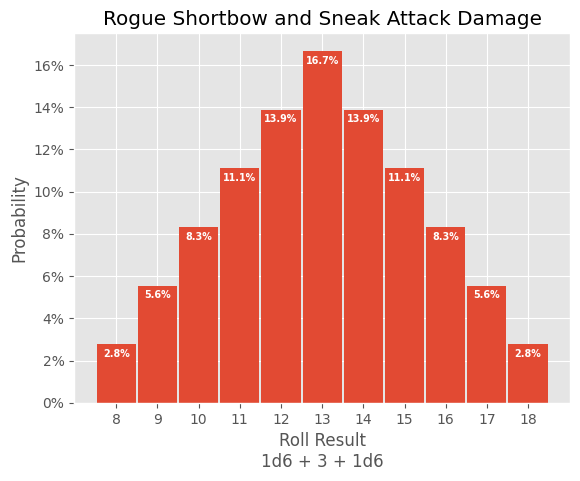

In [107]:
fig, ax = plot.subplots()

modified_d6 = np.arange(1 + 3, 7 + 3)
counts = []
for a, b in product(modified_d6, modified_d6):
    counts.append(a + b)
results = np.array(sorted(list(set(counts))))
for result in results:
    damage_probability = (counts.count(result) / len(modified_d6) ** 2) * 100
    ax.bar(result, damage_probability, width=0.95, color="C0")
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability - 0.6),
        color="white",
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

ax.set_title("Rogue Shortbow and Sneak Attack Damage")
ax.set_ylabel("Probability")
ax.set_xlabel("Roll Result\n1d6 + 3 + 1d6")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

## Notes and References

- ~~Dice roll averages are rounded down in the spirit of D&D ([Round Down - Basic Rules for Dungeons and Dragons (D&D) Fifth Edition (5e) - D&D Beyond](https://www.dndbeyond.com/sources/basic-rules/introduction#RoundDown))~~
- [[5e] The math and probability behind rolling with advantage! : DnD[5e] The math and probability behind rolling with advantage! : DnD](https://www.reddit.com/r/DnD/comments/802zzo/comment/dusrx2d/)
- [D&D Probability distributionsD&D Probability distributions](https://www.cl.cam.ac.uk/~rmk35/dropbears.html) (tabular data is inaccurate--off by 1)
- [I made a probability calculator for DnD dice rolls! : DungeonsAndDragons](https://www.reddit.com/r/DungeonsAndDragons/comments/uupw5t/i_made_a_probability_calculator_for_dnd_dice_rolls/)
- [Comment - DnD has led me to discover a rule of probability and I feel like Blaise Pascal : DnDDnD has led me to discover a rule of probability and I feel like Blaise Pascal : DnD](https://www.reddit.com/r/DnD/comments/i36b8b/comment/g0a72bv/) (more complex problems may require simulation instead of maths)
- [ryantam626/jupyterlab_code_formatter](https://github.com/ryantam626/jupyterlab_code_formatter) (note that the extension is configured in Jupyter Lab, not config files)